In [119]:
import numpy as np
import random

In [120]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [121]:
def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

In [122]:
def sampleChania(Chania, n_points):
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    for u in range(len(trueusers)):
        trueusers[u] = int(trueusers[u])
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

## Read dataset

In [123]:
Chania = np.genfromtxt('processedChania.csv', delimiter=',')

## Privitizer and Adversary

In [246]:
def privatizer(x):
    with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):
        l1 = tf.layers.dense(x, 16, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, x.shape[1].value)
    return l2


def adversary(y):
    with tf.variable_scope("ad", reuse=tf.AUTO_REUSE):
        l1 = tf.layers.dense(y, 16, activation=tf.nn.relu)
        # num users = 5
        l2 = tf.layers.dense(l1, 5, activation=tf.nn.softmax)
    return l2

## Signal Map Error

In [247]:
def signal_map_error(x, y):
    with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):

        # build model from input
        inputmodel = keras.Sequential([
            keras.layers.Dense(10, input_shape=(2, ), activation=tf.nn.relu),
            keras.layers.Dense(10, activation=tf.nn.relu),
            keras.layers.Dense(1)        
        ])
        optimizer = tf.train.FtrlOptimizer(0.001)
        inputmodel.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        inputmodel.fit(x[:,2:], x[:,1], steps_per_epoch=1, epochs=100, verbose=0)   

        # build model from output
        outputmodel = keras.Sequential([
            keras.layers.Dense(10, input_shape=(2, ), activation=tf.nn.relu),
            keras.layers.Dense(10, activation=tf.nn.relu),
            keras.layers.Dense(1)        
        ])
        outputmodel.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        outputmodel.fit(y[:,2:], y[:,1], steps_per_epoch=1, epochs=100, verbose=0)  
        
        # compare inputmodel(input) and outputmodel(input)
        map_error = tf.reduce_mean(tf.squared_difference(inputmodel(x[:,2:]), outputmodel(x[:,2:])))

    return map_error, inputmodel, outputmodel

## Classification Error

In [248]:
def classification_error(z, trueusers):
    with tf.variable_scope("ad", reuse=tf.AUTO_REUSE):
        class_error = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, z))
    return class_error

## Privatizer Loss

In [256]:
def privatizer_loss(x, y, trueusers, threshold):
    with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):
        penalty = 2
        
        c_e = classification_error(z, trueusers)
        s_m_e, _, _ = signal_map_error(x, y)
        
        zero = tf.constant(0, dtype=tf.float32)
        loss = -1*c_e + penalty*tf.math.maximum(zero, threshold-s_m_e)
        
    return loss        

## GAP

In [257]:
# initialize privatizer and adversary
# for i in range(n):
#     choose sample points
#     y = privatizer(x)
#     z = adversary(y)
#     for k in range(100):
#         train adversary
#     train privatizer

In [258]:
# initialize 
threshold = tf.constant(0.5, dtype=tf.float32)
x, trueusers = sampleChania(Chania, n_points=100)
y = privatizer(x)
z = adversary(y)
n = 10

# initialize loss variables
class_error = classification_error(z, trueusers)
priv_loss = privatizer_loss(x, y, trueusers, threshold)

# initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(n):

    # sample points
    x, trueusers = sampleChania(Chania, n_points=100)
    
    # run data through privatizer
    y = privatizer(x)
    
    # run data through adversary
    z = adversary(y)

    ad_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="ad")
    ad_train = tf.train.GradientDescentOptimizer(0.01).minimize(class_error, var_list = ad_vars)
    
    priv_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="priv")
    priv_train = tf.train.GradientDescentOptimizer(0.01).minimize(priv_loss, var_list = priv_vars)
    
    for k in range(1):
        
        # train adversary
        _, a_loss = sess.run((ad_train, class_error))
        
    # train privatizer
    _, p_loss = sess.run((priv_train, priv_loss))
    
    print("Iterations: %d\t Adversary loss: %.4f\t Privatizer loss: %.4f"%(i, a_loss,p_loss))

Iterations: 0	 Adversary loss: 1.6690	 Privatizer loss: -1.2291
Iterations: 1	 Adversary loss: 1.6683	 Privatizer loss: -1.4957
Iterations: 2	 Adversary loss: 1.6677	 Privatizer loss: -1.6617
Iterations: 3	 Adversary loss: 1.6672	 Privatizer loss: -1.6612
Iterations: 4	 Adversary loss: 1.6666	 Privatizer loss: -1.6607
Iterations: 5	 Adversary loss: 1.6661	 Privatizer loss: -1.6602
Iterations: 6	 Adversary loss: 1.6656	 Privatizer loss: -1.6597
Iterations: 7	 Adversary loss: 1.6651	 Privatizer loss: -1.6592
Iterations: 8	 Adversary loss: 1.6646	 Privatizer loss: -1.6587
Iterations: 9	 Adversary loss: 1.6641	 Privatizer loss: -1.6582


## Visualization

In [235]:
def plot_rssi(x, y, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
    ax[0].set_title("True Received Signal Strengths")
    
    ax[1].scatter(yarray[:,3], yarray[:,2], c=yarray[:,1])
    ax[1].set_title("Obfuscated Received Signal Strengths")

In [236]:
def plot_users(x, y, z, trueusers, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    zarray = z.eval(session=sess)
    u = trueusers.eval(session=sess)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].scatter(xarray[:,3], xarray[:,2], c=u)
    ax[0].set_title("True Users")
    
    ax[1].scatter(yarray[:,3], yarray[:,2], c=np.argmax(zarray, axis=1))
    ax[1].set_title("Adversarial Classified Users")

In [237]:
def plot_maps(x, inputmodel, outputmodel, sess):
    inputdata = x.eval(session=sess)
    xmin, xmax = np.min(inputdata[:,2]), np.max(inputdata[:,2])
    ymin, ymax = np.min(inputdata[:,3]), np.max(inputdata[:,3])
    testpoints = np.mgrid[xmin:xmax:15j, ymin:ymax:15j].reshape(2,-1).T
    
    grid = tf.constant(testpoints, dtype=tf.float32)

    inputmap = inputmodel.predict_on_batch(grid.eval(session=sess))
    outputmap = outputmodel.predict_on_batch(grid.eval(session=sess))

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
    ax[0].set_title("Map created from True Data")
    ax[1].scatter(testpoints[:,1], testpoints[:,0], c=outputmap[:,0])
    ax[1].set_title("Map created from Obfuscated Data")

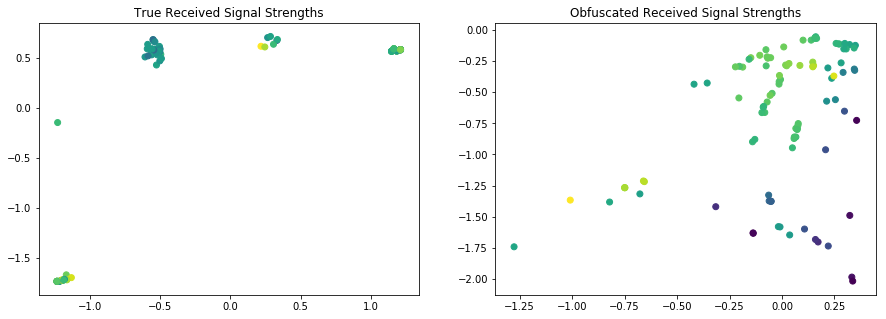

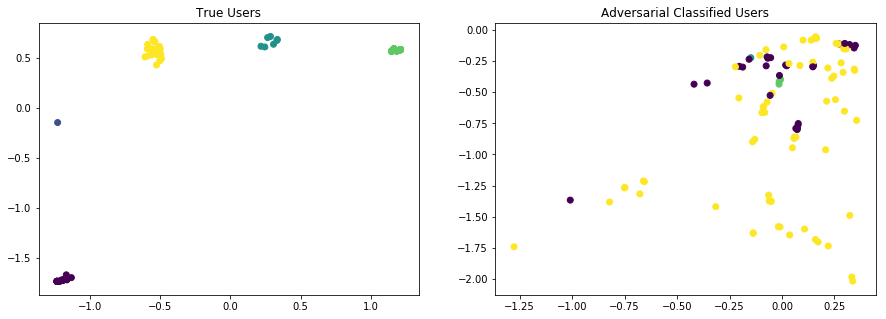

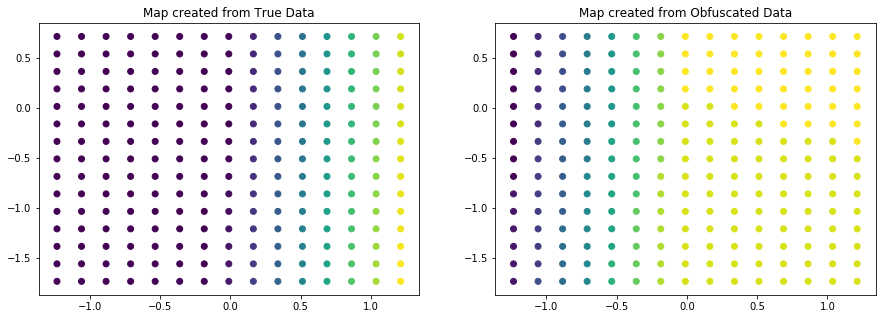

In [259]:
plot_rssi(x, y, sess)
plot_users(x, y, z, trueusers, sess)
_, inputmodel, outputmodel = signal_map_error(x, y)
plot_maps(x, inputmodel, outputmodel, sess)

## Notes

#### Metaparameters to consider playing with:
1. number of layers & units in privatizer and adversary
2. number of layers and & units in signal map models
3. penalty
4. threshold
5. number of points to train on each iteration
6. ratio of adversary training steps to privatizer training steps

#### Additional note:  
I am calculating signal map error as the mean square error of the ouput of two models when they are both fed with the input x. Should I instead be feeding a uniform input of hypothetical points (like the visualization?)